In [ ]:
# 读取数据
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('harmonic_oscillator_trajectory.csv')
x = data['x'].to_numpy()
y = data['p'].to_numpy()
N = x.shape[0]
data = np.vstack((x,y)).T
print(f'样本数量为{N}')



样本数量为10000


In [42]:
data_centered = data - np.mean(data,axis=0)
cov_matrix = np.cov(data_centered, rowvar=False)

# 确保协方差矩阵可逆
# 通过加一个小的正则化项来确保矩阵可逆（常用方法）
epsilon = 0 # 你可以调整这个值
cov_matrix += np.eye(cov_matrix.shape[0]) * epsilon

# 计算协方差矩阵的特征值和特征向量
eigvals, eigvecs = np.linalg.eigh(cov_matrix)

# 排序特征值和特征向量
sorted_indices = np.argsort(eigvals)[::-1]  # 从大到小排序
eigvals_sorted = eigvals[sorted_indices]
eigvecs_sorted = eigvecs[:, sorted_indices]

# 将数据投影到主成分上
data_pca = np.dot(data_centered, eigvecs_sorted)

# 白化：将特征值归一化，确保每个主成分的方差为 1
data_preprocessed = data_pca / np.sqrt(eigvals_sorted + epsilon)

print(eigvals_sorted)

[0.99386863 0.49127103]


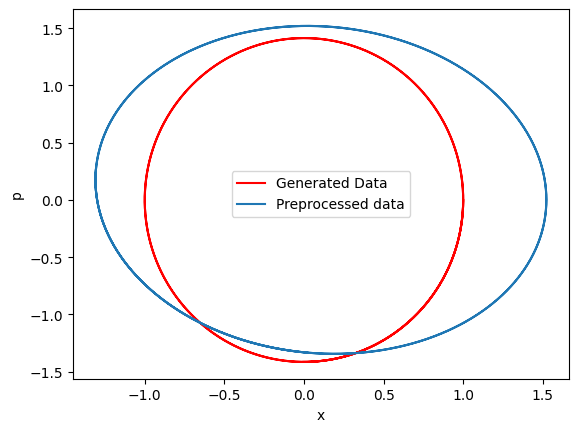

In [39]:
# 可视化数据
plt.plot(x, y, color='r', label="Generated Data")
plt.plot(data_preprocessed[:,0],data_preprocessed[:,1],label='Preprocessed data')


plt.xlabel("x")
plt.ylabel("p")
plt.legend()
plt.show()

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 定义神经网络
class LocalMC(nn.Module):
    def __init__(self):
        super(LocalMC, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # 输入层到隐藏层
        self.fc2 = nn.Linear(64, 64)  # 隐藏层
        self.fc3 = nn.Linear(64, 2)   # 隐藏层到瓶颈层
        self.fc4
        

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # ReLU激活函数
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # 最后一层没有激活函数，输出为原始数据
        return x